In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

from ensemblecalibration.config.config_cal_test import create_config_proper_losses
from ensemblecalibration.data.experiments_cal_test import get_experiment

from ensemblecalibration.data.dataset import MLPDataset
from ensemblecalibration.losses import GeneralizedBrierLoss
from ensemblecalibration.utils.helpers import calculate_pbar
from ensemblecalibration.meta_model import (
    MLPCalW,
    CredalSetCalibrator,
    TemperatureScalingCalibrator,
)
from ensemblecalibration.meta_model.train import get_optim_lambda_mlp
from ensemblecalibration.utils.minimization import calculate_min

In [2]:
config = create_config_proper_losses()

In [3]:
config

{'LP': {'experiment': 'gp',
  'test': <function ensemblecalibration.cal_test.bootstrap_test.npbe_test_ensemble(alpha: list, x_inst: numpy.ndarray, p_preds: numpy.ndarray, y_labels: numpy.ndarray, params: dict, verbose: bool = True)>,
  'params': {'optim': 'mlp',
   'n_samples': 2000,
   'n_resamples': 100,
   'n_classes': 3,
   'n_members': 5,
   'obj': <function ensemblecalibration.cal_estimates.kde_ece.ece_kde_obj(p_bar: numpy.ndarray, y: numpy.ndarray, params: dict)>,
   'obj_lambda': <function ensemblecalibration.cal_estimates.kde_ece.ece_kde_obj_lambda(weights_l, p_probs, y_labels, params, x_dep: bool = False)>,
   'bw': 0.01,
   'loss': GeneralizedBrierLoss(),
   'n_epochs': 500,
   'lr': 0.0001,
   'batch_size': 16,
   'patience': 100,
   'hidden_layers': 3,
   'hidden_dim': 64,
   'x_dep': True,
   'deg': 2,
   'device': 'cpu',
   'bounds_p': [[0.5, 0.8], [0.7, 0.9]],
   'p': 2}}}

In [4]:
data, _, _ = get_experiment(config["LP"], h0=True)

In [5]:
x_inst=data[0]
p_preds=data[1]
p_bar = data[2]
y_labels=data[3]

Text(0, 0.5, 'p')

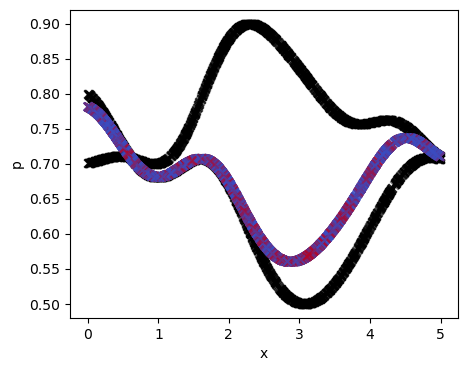

In [12]:
# plot x, p_preds

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for i in range(2):
    ax.scatter(x_inst.squeeze(), p_preds[:, i, 0], c="black", alpha=0.5, marker="x",
               )
    #make scatterplot markersize smaller
    ax.scatter(x_inst.squeeze(), p_bar[:, 0], c=y_labels, cmap="coolwarm", alpha=0.5, marker="x",
               )
ax.set_xlabel("x")
ax.set_ylabel("p")

In [22]:
dataset = MLPDataset(x_train=x_inst, P=p_preds, y=y_labels)
model = CredalSetCalibrator(comb_model=MLPCalW, cal_model=TemperatureScalingCalibrator,
                            in_channels=1, n_classes=2, n_ensembles=2, hidden_dim=32, hidden_layers=2,
                            )



In [23]:
# split data in train, val, test
dataset_size = len(dataset)
indices = list(range(dataset_size))

# First, split off 40% of the data for validation+test
train_indices, temp_indices = train_test_split(
    indices, test_size=0.4, random_state=42
)

# Then split the temporary set into two equal parts for validation and test (20% each)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, random_state=42
)

# Create the subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [24]:
# get instances from test dataset
x_test = test_dataset.dataset.x_train[test_dataset.indices]
p_preds_test = test_dataset.dataset.p_probs[test_dataset.indices]

In [25]:
weights_l, loss_train, loss_val = get_optim_lambda_mlp(dataset_train=train_dataset, dataset_val=val_dataset, dataset_test=test_dataset,
                      model=model, loss=GeneralizedBrierLoss(), lr=0.0001, n_epochs=1000,
                     verbose=True)

Epoch 1/1000: train=0.4346, val=0.4378
Epoch 10/1000: train=0.4284, val=0.4356
Epoch 20/1000: train=0.4287, val=0.4337
Epoch 30/1000: train=0.4275, val=0.4328
Epoch 40/1000: train=0.4288, val=0.4326
Epoch 50/1000: train=0.4297, val=0.4326
Epoch 60/1000: train=0.4267, val=0.4327
Epoch 70/1000: train=0.4301, val=0.4329
Epoch 80/1000: train=0.4309, val=0.4331
Epoch 90/1000: train=0.4299, val=0.4333
Epoch 100/1000: train=0.4284, val=0.4335
Epoch 110/1000: train=0.4284, val=0.4337
Epoch 120/1000: train=0.4264, val=0.4340
Epoch 130/1000: train=0.4296, val=0.4342
Epoch 140/1000: train=0.4285, val=0.4344
Epoch 150/1000: train=0.4285, val=0.4344
Epoch 160/1000: train=0.4269, val=0.4345
Epoch 170/1000: train=0.4274, val=0.4346
Epoch 180/1000: train=0.4260, val=0.4348
Epoch 190/1000: train=0.4295, val=0.4350
Epoch 200/1000: train=0.4313, val=0.4352
Epoch 210/1000: train=0.4270, val=0.4351
Epoch 220/1000: train=0.4283, val=0.4353
Epoch 230/1000: train=0.4319, val=0.4354
Epoch 240/1000: train=0.430

In [20]:
p_bar_pred = calculate_pbar(weights_l=weights_l, p_preds=p_preds_test)

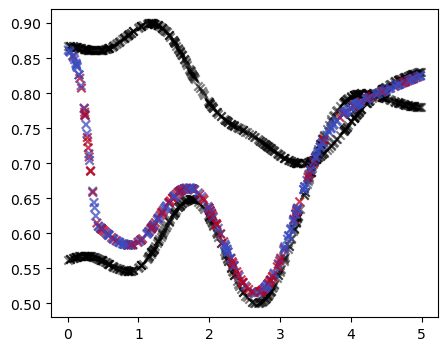

In [21]:
# plot predicted combination
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for i in range(2):
    ax.scatter(x_test.squeeze(), p_preds_test[:, i, 0], c="black", alpha=0.5, marker="x",
               )
    ax.scatter(x_test.squeeze(), p_bar_pred[:, 0], c=y_labels[test_indices], cmap="coolwarm", alpha=0.5, marker="x",
               )

In [6]:
minstat, x_inst_test, l_weights_test, p_bar_test, y_test, p_preds_test = calculate_min(
    x_inst=x_inst, p_probs=p_preds, y_labels=y_labels, params=config["LP"]["params"],
    verbose=True
)

Epoch 1/500: train=0.4386, val=0.4336
Epoch 10/500: train=0.4372, val=0.4317
Epoch 20/500: train=0.4364, val=0.4318
Epoch 30/500: train=0.4350, val=0.4320
Epoch 40/500: train=0.4344, val=0.4314
Epoch 50/500: train=0.4336, val=0.4314
Epoch 60/500: train=0.4331, val=0.4323
Epoch 70/500: train=0.4332, val=0.4312
Epoch 80/500: train=0.4332, val=0.4325
Epoch 90/500: train=0.4338, val=0.4323
Epoch 100/500: train=0.4334, val=0.4317
Epoch 110/500: train=0.4330, val=0.4319
Epoch 120/500: train=0.4334, val=0.4319
Epoch 130/500: train=0.4330, val=0.4315
Epoch 140/500: train=0.4332, val=0.4325
Epoch 150/500: train=0.4331, val=0.4321
Epoch 160/500: train=0.4333, val=0.4325
Epoch 170/500: train=0.4329, val=0.4318
Epoch 180/500: train=0.4333, val=0.4323
Early stopping at epoch 183
Best epoch: 83, Best val loss: 0.4309413325786591
Stopped early at epoch 183


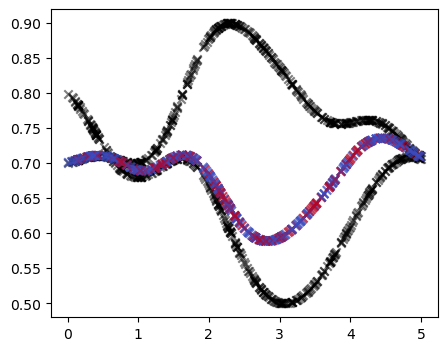

In [10]:
# plot p_preds_test, p_bar_test
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
for i in range(2):
    ax.scatter(x_inst_test.squeeze(), p_preds_test[:, i, 0], c="black", alpha=0.5, marker="x",
               )
    ax.scatter(x_inst_test.squeeze(), p_bar_test[:, 0], c=y_test, cmap="coolwarm", alpha=0.5, marker="x",
               )